In [1]:
from __future__ import division
from importlib import reload
from modules import * 
fig_savedir = '../data/figures/'

grid_params = {
    'y_height':   20,
    'x_width':    20,
    'walls':      False,
    'rho':        0,
    'maze_type':  'none',
    'port_shift': 'none'
}


agent_params = {
    'load_model':   True,
    'load_dir':     '../data/outputs/gridworld/MF{}{}training.pt'.format(grid_params['x_width'],grid_params['y_height']),
    'action_dims':  6, #=len(maze.actionlist)
    'batch_size':   1,
    'gamma':        0.98, #discount factor
    'eta':          5e-4,
    'temperature':  1,
    'use_EC':       False,
    'cachelim':     100, # memory limit should be ~75% of #actions x #states
    'state_type':   'conv'
}

run_dict = {
    'NUM_EVENTS':   150,
    'NUM_TRIALS':   5000,
    'print_freq':   1/10,
    'total_loss':   [[],[]],
    'total_reward': [],
    'val_maps':     [],
    'policies':     [{},{}],
    'deltas':       [],
    'spots':        [],
    'vls':          []
}

In [2]:
#make environment
maze = eu.gridworld(grid_params)
maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])
env = eu.gymworld(maze) # openAI-like wrapper 

#update agent params dictionary with layer sizes appropriate for environment 
agent_params = sg.gen_input(maze, agent_params)

MF,opt = ac.make_agent(agent_params)

agent_params['cachelim'] = int(0.75*np.prod(maze.grid.shape))

EC = ec.ep_mem(MF,agent_params['cachelim']) 

/home/annik/.local/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/annik/.local/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/annik/.local/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object'

In [3]:
# write a function for runs with episodic mem and without -- take use_EC as a param
# assume just for conv inputs 
def run_trials(run_dict, use_EC, **kwargs):
    save_data  = kwargs.get('save', True)
    NUM_TRIALS = 2 #run_dict['NUM_TRIALS']
    NUM_EVENTS = 50 #run_dict['NUM_EVENTS']
    
    blocktime = time.time()
    
    if use_EC:
        EC.reset_cache()
        add_mem_dict = {} #dictionary of items which get put into memory cache
        timestamp    = 0
        

        for trial in range(NUM_TRIALS):
            tt = 0
            trialstart_stamp = timestamp

            reward_sum   = 0
            v_last       = 0

            env.reset() 

            state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))
            MF.reinit_hid() #reinit recurrent hidden layers

            for event in range(NUM_EVENTS):
                # pass state through EC module
                policy_, value_, lin_act_ = MF(state)
                add_mem_dict['state'] = maze.cur_state

                choice, policy, value = ac.select_action(MF,policy_, value_)
                if event < NUM_EVENTS: 
                    next_state, reward, done, info = env.step(choice)

                MF.rewards.append(reward)

                delta = reward + agent_params['gamma']*value - v_last  #compute eligibility trace/rpe approximation

                add_mem_dict['activity']  = tuple(lin_act_.view(-1).data)
                add_mem_dict['action']    = choice
                add_mem_dict['delta']     = delta
                add_mem_dict['timestamp'] = timestamp            
                
                st = time.time()
                EC.add_mem(add_mem_dict)#add event to memory cache
                tx = time.time()-st
                tt += tx
                #print(tx)
                
                # because we need to include batch size of 1 
                state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))
                reward_sum += reward

                v_last = value
                timestamp += 1

            p_loss, v_loss = ac.finish_trial(MF,agent_params['gamma'],opt)
            #print(tt)

            if save_data:
                #value_map = ac.generate_values(maze,MF)
                run_dict['total_loss'][0].append(p_loss.data[0])
                run_dict['total_loss'][1].append(v_loss.data[0])
                run_dict['total_reward'].append(reward_sum)
                #run_dict['val_maps'].append(value_map.copy())
                #run_dict['deltas'].append(track_deltas)
                #run_dict['spots'].append(track_spots)
                #run_dict['vls'].append(visited_locs)

            if trial ==0 or trial%100==0 or trial == NUM_TRIALS-1:
                print("[{0}]  Trial {1} TotRew = {2} ({3:.3f}s)".format(time.strftime("%H:%M:%S", time.localtime()), trial+1, reward_sum,time.time()-blocktime)) #print("[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)) 
                blocktime = time.time()


    else:
        for trial in range(NUM_TRIALS):
            reward_sum   = 0
            v_last       = 0
            track_deltas = []
            track_spots  = []
            visited_locs = []

            env.reset() 
            state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))
            MF.reinit_hid() #reinit recurrent hidden layers

            for event in range(NUM_EVENTS):
                policy_, value_ = MF(state, agent_params['temperature'])[0:2]
                choice, policy, value = ac.select_action(MF,policy_, value_)

                if event < NUM_EVENTS: 
                    next_state, reward, done, info = env.step(choice)

                MF.rewards.append(reward)
                delta = reward + agent_params['gamma']*value - v_last  #compute eligibility trace/rpe approximation
                state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))

                reward_sum += reward
                v_last = value

            p_loss, v_loss = ac.finish_trial(MF,agent_params['gamma'],opt)

            if save_data:
                #value_map = ac.generate_values(maze,MF)
                run_dict['total_loss'][0].append(p_loss.data[0])
                run_dict['total_loss'][1].append(v_loss.data[0])
                run_dict['total_reward'].append(reward_sum)
                #run_dict['val_maps'].append(value_map.copy())
                #run_dict['deltas'].append(track_deltas)
                #run_dict['spots'].append(track_spots)
                #run_dict['vls'].append(visited_locs)

            if trial ==0 or trial%10==0 or trial == NUM_TRIALS-1:
                print("[{0}]  Trial {1} TotRew = {2} ({3:.3f}s)".format(time.strftime("%H:%M:%S", time.localtime()), trial+1, reward_sum,time.time()-blocktime)) #print("[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)) 
                blocktime = time.time()


In [4]:
a1 = run_trials(run_dict, True)


[11:00:55]  Trial 1 TotRew = 33 (0.135s)
[11:00:55]  Trial 2 TotRew = 36 (0.102s)


/home/annik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/annik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


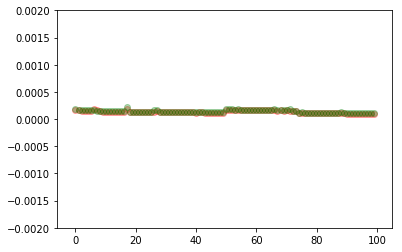

In [5]:
cs =['r','g','b','c']
plt.figure()
for i in range(len(EC.stupid_df)):
    xs = np.arange(len(EC.stupid_df[i]))
    ys = EC.stupid_df[i]
    
    plt.scatter(xs, ys, c=cs[i], alpha=0.3)
plt.ylim([-0.002,0.002])
plt.show()

In [ ]:
plt.figure(1)
plt.plot(run_dict['total_reward'])
plt.ylim([0,run_dict['NUM_EVENTS']])
 
plt.figure(2)
plt.plot(run_dict['total_loss'][0], label = 'pol')
plt.plot(run_dict['total_loss'][1], label = 'val')
plt.legend(loc=0)
plt.show()
plt.close()
#gp.print_value_maps(maze, run_dict['val_maps'], maps=0, val_range=(-1,50), save_dir=fig_savedir, title='Value Map')

In [ ]:
ac.torch.save(MF,agent_params['load_dir'])